Số quan sát: 40
Số biến exogenous: 4
Các biến: ['Inflation', 'Population', 'FDI', 'TradeBalance']

ADF Statistic: 6.311456094847122
p-value: 1.0
Chuỗi KHÔNG dừng → sai phân bậc 1
Train samples: 31
Test samples : 8

===== TÓM TẮT MÔ HÌNH ARIMAX =====
                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   31
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -728.660
Date:                Sat, 17 Jan 2026   AIC                           1471.320
Time:                        13:19:21   BIC                           1481.128
Sample:                             0   HQIC                          1474.458
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_mode

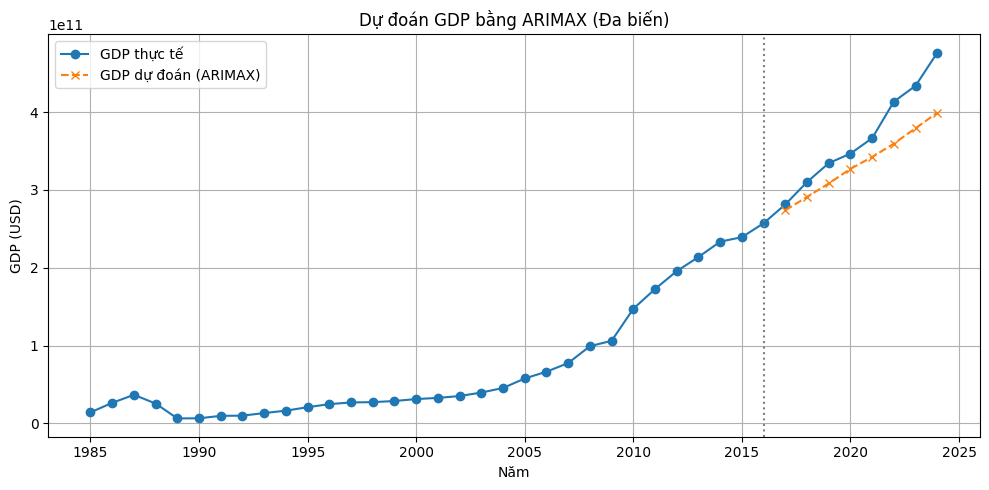

In [1]:
# ===== ARIMAX ĐA BIẾN DỰ ĐOÁN GDP =====

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. LOAD DATA
df = pd.read_csv("macro_vietnam_processed.csv")

df["Year"] = pd.to_numeric(df["Year"])
df = df.sort_values("Year").reset_index(drop=True)

years = df["Year"].values
gdp = df["GDP"].astype(float)

# 2. CHỌN CÁC BIẾN ĐẦU VÀO
feature_cols = ['Inflation', 'Population', 'FDI', 'TradeBalance']
exog_data = df[feature_cols].values

print("Số quan sát:", len(gdp))
print("Số biến exogenous:", len(feature_cols))
print("Các biến:", feature_cols)

# 3. KIỂM TRA TÍNH DỪNG (ADF TEST)
adf_result = adfuller(gdp)
print("\nADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

# Nếu không dừng → sai phân bậc 1
if adf_result[1] > 0.05:
    print("Chuỗi KHÔNG dừng → sai phân bậc 1")
    gdp_diff = gdp.diff().dropna()
    exog_diff = exog_data[1:]  # Bỏ hàng đầu do sai phân
    d = 1
else:
    print("Chuỗi DỪNG")
    gdp_diff = gdp
    exog_diff = exog_data
    d = 0

# 4. TRAIN / TEST SPLIT (80% / 20%)
train_size = int(len(gdp_diff) * 0.8)

train_endog = gdp_diff.iloc[:train_size]
test_endog = gdp_diff.iloc[train_size:]

train_exog = exog_diff[:train_size]
test_exog = exog_diff[train_size:]

print("Train samples:", len(train_endog))
print("Test samples :", len(test_endog))

# 5. HUẤN LUYỆN ARIMAX
# (p, d, q) = (1, d, 1) với biến exogenous
model = ARIMA(train_endog, order=(1, d, 1), exog=train_exog)
model_fit = model.fit()

print("\n===== TÓM TẮT MÔ HÌNH ARIMAX =====")
print(model_fit.summary())

# 6. DỰ ĐOÁN
forecast_diff = model_fit.forecast(steps=len(test_endog), exog=test_exog)

# Nếu có sai phân → hoàn nguyên GDP
if d == 1:
    last_gdp = gdp.iloc[train_size]
    forecast = last_gdp + forecast_diff.cumsum()
    actual = gdp.iloc[train_size+1:]
else:
    forecast = forecast_diff
    actual = test_endog

# 7. ĐÁNH GIÁ
mae  = mean_absolute_error(actual, forecast)
rmse = np.sqrt(mean_squared_error(actual, forecast))
r2   = r2_score(actual, forecast)

print("\n===== ĐÁNH GIÁ ARIMAX ĐA BIẾN =====")
print(f"MAE  = {mae:,.0f} USD")
print(f"RMSE = {rmse:,.0f} USD")
print(f"R²   = {r2:.4f}")

# 8. BIỂU ĐỒ
plt.figure(figsize=(10,5))
plt.plot(years, gdp, label="GDP thực tế", marker="o")
plt.plot(years[train_size+1:], forecast, 
         label="GDP dự đoán (ARIMAX)", 
         marker="x", linestyle="--")
plt.axvline(years[train_size], color="gray", linestyle=":")
plt.xlabel("Năm")
plt.ylabel("GDP (USD)")
plt.title("Dự đoán GDP bằng ARIMAX (Đa biến)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()